# Fantasy Premier League Football Team Selector
The aim of this notebook is to use programming to help select a team that could achieve a strong score in Fantasy Premier League.

Using historical full season statistics, I aim to create a machine learning model that uses a players stats in the previous year to predict their points performance in the following season.

With these predictions - supplemented with some human adjustments due to transfer rumours and factors difficult for the machine to assess - we then use brute force to select the team combination with the maximum predicted points (subject to the constraints of the FPL rules).

### Note
This notebook assumes the reader has at least some familiarity with Python, machine learning, football and the Fantasy Premier League statistics (though rules and constraints are explained).

## Strategy - find players with highest (consistent) points per game
For the players in the upcoming season where there is sufficient previous season data, we aim to use machine learning to build a model to predict points per game (based on their performance in the previous season).

We will use only players that play a sigificant amount - so we avoid inconsistent performers.

But this means there is a big drawback - we exclude players that didn't play in the Premier League in the previous season. Newly promoted teams are excluded and new transfers from other leagues are excluded.

Also, we're playing a long-term strategy - rather than looking at week-by-week data. So the aim will be to pick a team that never needs to change as it should perform well over the season as a whole - unless there are injuries/transfers in which case an update will be needed of course!

### Human input required!
This model can identify players that should achieve high points per game - but human factors will give better intuition on the likelihood that a player plays a lot in this season - I chose this approach rather than assuming playing time would be the same/similar to the previous season.

## Import modules

In [1]:
import requests
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_val_score, RepeatedKFold
from sklearn.metrics import mean_absolute_error

from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.ensemble import StackingRegressor

from itertools import combinations
import time

pd.options.display.max_columns = 50 # allow for easier reading of finalised dataframes

# below code used to originally download latest pre-season data (on 12th Sept 2020)
#- but subsequently I saved it (so it doesn't update after season has begun)
    # url = "https://fantasy.premierleague.com/api/bootstrap-static/"
    # response = requests.get(url)
    # response.raise_for_status() # checks site loads and raises exception, if not
    # json = response.json()
    # teams_df = pd.DataFrame(json["teams"])
    # teams_df.rename(columns = {'code': 'team_code', 'name': 'team_name'}, inplace = True)
    # elements_df = pd.DataFrame(json["elements"])

## Download latest season data
Below we download the latest available data for the 2020-21 pre-season.

The statistics are a mixture of old and new statistics - to be updated as the season progresses.

The only data we will use from this dataset for machine learning are:
   * from `team_df` - "team_name" and "strength_" statistics - we will map the team names and attack/defence stats into the historical data (as it wasn't easily available so we will have to estimate that team strength is largely unchanged in the past few years)
   * from `elements_df` - "now_cost" is the latest accurate cost which we'll use to select the teams at the end

In [2]:
teams_df = pd.read_csv(r"C:\Users\Dexx6\Documents\MyProjects\Jupyter Notebooks\FPL_data\data\2020-21\pre-season_teams.csv")
elements_df = pd.read_csv(r"C:\Users\Dexx6\Documents\MyProjects\Jupyter Notebooks\FPL_data\data\2020-21\pre-season_elements.csv")

In [3]:
teams_df # the only useful columns in this dataframe are "team_name" and team "strength_" columns

,Unnamed: 0,team_code,draw,form,id,loss,team_name,played,points,position,short_name,strength,team_division,unavailable,win,strength_overall_home,strength_overall_away,strength_attack_home,strength_attack_away,strength_defence_home,strength_defence_away,pulse_id
0,0,3,0,NaN,1,0,Arsenal,0,0,0,ARS,4,NaN,False,0,1190,1270,1190,1200,1160,1270,1
1,1,7,0,NaN,2,0,Aston Villa,0,0,0,AVL,2,NaN,False,0,1050,1080,1010,1080,1000,1110,2
2,2,36,0,NaN,3,0,Brighton,0,0,0,BHA,2,NaN,False,0,1070,1070,1100,1130,1060,1060,131
3,3,90,0,NaN,4,0,Burnley,0,0,0,BUR,3,NaN,False,0,1140,1150,1130,1240,1050,1170,43
4,4,8,0,NaN,5,0,Chelsea,0,0,0,CHE,4,NaN,False,0,1200,1260,1140,1270,1240,1250,4
5,5,31,0,NaN,6,0,Crystal Palace,0,0,0,CRY,3,NaN,False,0,1080,1070,1080,1190,1010,1040,6
6,6,11,0,NaN,7,0,Everton,0,0,0,EVE,3,NaN,False,0,1100,1180,1090,1190,1150,1180,7
7,7,54,0,NaN,8,0,Fulham,0,0,0,FUL,2,NaN,False,0,1000,1030,1010,1030,1000,1050,34
8,8,13,0,NaN,9,0,Leicester,0,0,0,LEI,4,NaN,False,0,1180,1230,1180,1260,1220,1250,26
9,9,2,0,NaN,10,0,Leeds,0,0,0,LEE,2,NaN,False,0,1030,1040,1040,1070,990,990,9


In [4]:
elements_df # there are far too many columns here - we pick out key features more clearly later

,Unnamed: 0,chance_of_playing_next_round,chance_of_playing_this_round,code,cost_change_event,cost_change_event_fall,cost_change_start,cost_change_start_fall,dreamteam_count,element_type,ep_next,ep_this,event_points,first_name,form,id,in_dreamteam,news,news_added,now_cost,photo,points_per_game,second_name,selected_by_percent,special,...,penalties_saved,penalties_missed,yellow_cards,red_cards,saves,bonus,bps,influence,creativity,threat,ict_index,influence_rank,influence_rank_type,creativity_rank,creativity_rank_type,threat_rank,threat_rank_type,ict_index_rank,ict_index_rank_type,corners_and_indirect_freekicks_order,corners_and_indirect_freekicks_text,direct_freekicks_order,direct_freekicks_text,penalties_order,penalties_text
0,0,NaN,NaN,37605,0,0,0,0,0,3,3.4,NaN,0,Mesut,0.0,1,False,NaN,NaN,70,37605.jpg,2.9,Özil,1.4,False,...,0,0,1,0,0,1,256,223.6,582.9,190.0,99.8,260,113,36,30,178,98,138,74,3.0,NaN,NaN,NaN,NaN,NaN
1,1,0.0,NaN,39476,0,0,0,0,0,2,0.0,NaN,0,Sokratis,0.0,2,False,Calf injury - Expected back 19 Sep,2020-09-11T11:00:08.600094Z,50,39476.jpg,3.0,Papastathopoulos,0.3,False,...,0,0,6,0,0,5,305,436.2,36.8,110.0,58.5,146,54,302,107,229,66,239,75,NaN,NaN,NaN,NaN,NaN,NaN
2,2,0.0,NaN,41270,0,0,0,0,0,2,0.0,NaN,0,David,0.0,3,False,Neck - Unknown return date,2020-09-10T14:30:11.632386Z,55,41270.jpg,2.8,Luiz Moreira Marinho,1.4,False,...,0,0,5,2,0,10,494,701.6,106.7,211.0,102.1,50,18,227,62,164,32,133,35,NaN,NaN,2.0,NaN,NaN,NaN
3,3,NaN,NaN,54694,0,0,0,0,0,3,5.0,NaN,0,Pierre-Emerick,0.0,4,False,NaN,NaN,120,54694.jpg,5.7,Aubameyang,48.4,False,...,0,0,3,1,0,37,807,1006.0,479.6,1369.0,285.2,8,4,56,44,9,3,11,7,NaN,NaN,4.0,NaN,1.0,NaN
4,4,NaN,NaN,58822,0,0,0,0,0,2,3.1,NaN,0,Cédric,0.0,5,False,NaN,NaN,50,58822.jpg,2.9,Soares,0.6,False,...,0,0,1,0,0,3,286,349.0,218.9,118.0,68.7,186,69,163,35,228,65,207,60,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
516,516,NaN,NaN,428610,0,0,0,0,0,3,1.0,NaN,0,Bruno André,0.0,475,False,NaN,NaN,45,428610.jpg,1.0,Cavaco Jordao,0.6,False,...,0,0,0,0,0,0,4,2.6,10.4,0.0,1.3,380,163,339,158,439,174,380,163,NaN,NaN,NaN,NaN,NaN,NaN
517,517,NaN,NaN,474003,0,0,0,0,0,4,1.3,NaN,0,Leonardo,0.0,476,False,NaN,NaN,50,474003.jpg,0.0,Campana,0.3,False,...,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,490,55,487,55,485,55,490,55,NaN,NaN,NaN,NaN,NaN,NaN
518,518,NaN,NaN,449988,0,0,0,0,0,4,1.5,NaN,0,Fabio,0.0,504,False,NaN,NaN,55,449988.jpg,0.0,Silva,1.3,False,...,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,509,61,509,61,507,61,509,61,NaN,NaN,NaN,NaN,NaN,NaN
519,519,NaN,NaN,111291,0,0,0,0,0,2,2.1,NaN,0,Fernando,0.0,505,False,NaN,NaN,50,111291.jpg,0.0,Marçal,0.3,False,...,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,472,184,469,184,464,183,472,184,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
# we add the player's team "strength_attack_", "strength_defence_" and "team_name" columns
# and we set the index to be the unique player "code"

elements_df = elements_df.merge(
                teams_df[["team_code", "strength_attack_home", "strength_attack_away",
                           "strength_defence_home", "strength_defence_away",
                           "team_name"]],
                on = 'team_code', how = 'left').set_index("code")

In [6]:
elements_df.columns # there are many columns, we'll trim it significantly

Index(['Unnamed: 0', 'chance_of_playing_next_round',
       'chance_of_playing_this_round', 'cost_change_event',
       'cost_change_event_fall', 'cost_change_start', 'cost_change_start_fall',
       'dreamteam_count', 'element_type', 'ep_next', 'ep_this', 'event_points',
       'first_name', 'form', 'id', 'in_dreamteam', 'news', 'news_added',
       'now_cost', 'photo', 'points_per_game', 'second_name',
       'selected_by_percent', 'special', 'squad_number', 'status', 'team',
       'team_code', 'total_points', 'transfers_in', 'transfers_in_event',
       'transfers_out', 'transfers_out_event', 'value_form', 'value_season',
       'web_name', 'minutes', 'goals_scored', 'assists', 'clean_sheets',
       'goals_conceded', 'own_goals', 'penalties_saved', 'penalties_missed',
       'yellow_cards', 'red_cards', 'saves', 'bonus', 'bps', 'influence',
       'creativity', 'threat', 'ict_index', 'influence_rank',
       'influence_rank_type', 'creativity_rank', 'creativity_rank_type',
       

## Historical data for model training
Below we download the player data (equivalent to `elements_df` above) from the four previous seasons that are available.

In [7]:
# data source: https://github.com/vaastav/Fantasy-Premier-League

data_2016_17 = pd.read_csv(r"C:\Users\Dexx6\Documents\MyProjects\Jupyter Notebooks\FPL_data\data\2016-17\players_raw.csv")
data_2017_18 = pd.read_csv(r"C:\Users\Dexx6\Documents\MyProjects\Jupyter Notebooks\FPL_data\data\2017-18\players_raw.csv")
data_2018_19 = pd.read_csv(r"C:\Users\Dexx6\Documents\MyProjects\Jupyter Notebooks\FPL_data\data\2018-19\players_raw.csv")
data_2019_20 = pd.read_csv(r"C:\Users\Dexx6\Documents\MyProjects\Jupyter Notebooks\FPL_data\data\2019-20\players_raw.csv")

In [8]:
# we merge in the same way as with the latest data
# adding team strength and team name stats and indexing by unique player code

data_2016_17 = data_2016_17.merge(teams_df[["team_code", "team_name",
                        "strength_attack_home", "strength_attack_away",
                        "strength_defence_home", "strength_defence_away"
                        ]],
                    on = 'team_code', how = 'left').set_index("code")
data_2017_18 = data_2017_18.merge(teams_df[["team_code", "team_name",
                        "strength_attack_home", "strength_attack_away",
                        "strength_defence_home", "strength_defence_away"
                        ]],
                    on = 'team_code', how = 'left').set_index("code")
data_2018_19 = data_2018_19.merge(teams_df[["team_code", "team_name",
                        "strength_attack_home", "strength_attack_away",
                        "strength_defence_home", "strength_defence_away"
                        ]],
                    on = 'team_code', how = 'left').set_index("code")
data_2019_20 = data_2019_20.merge(teams_df[["team_code", "team_name",
                        "strength_attack_home", "strength_attack_away",
                        "strength_defence_home", "strength_defence_away"
                        ]],
                    on = 'team_code', how = 'left').set_index("code")

In [9]:
data_2019_20.sample(5)

,assists,bonus,bps,chance_of_playing_next_round,chance_of_playing_this_round,clean_sheets,cost_change_event,cost_change_event_fall,cost_change_start,cost_change_start_fall,creativity,creativity_rank,creativity_rank_type,dreamteam_count,element_type,ep_next,ep_this,event_points,first_name,form,goals_conceded,goals_scored,ict_index,ict_index_rank,ict_index_rank_type,...,saves,second_name,selected_by_percent,special,squad_number,status,team,team_code,threat,threat_rank,threat_rank_type,total_points,transfers_in,transfers_in_event,transfers_out,transfers_out_event,value_form,value_season,web_name,yellow_cards,team_name,strength_attack_home,strength_attack_away,strength_defence_home,strength_defence_away
code,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
432735,0,0,25,100,100,0,0,0,-1,1,18.2,407,60,0,4,-0.5,-0.5,1,Adam,1.0,9,0,7.1,439,61,...,0,Idah,0.1,False,None,a,14,45,47.0,352,57,13,21977,0,17712,0,0.2,3.0,Idah,0,NaN,NaN,NaN,NaN,NaN
156074,0,2,96,100,100,1,0,0,-1,1,4.8,441,164,0,2,1.3,1.2,0,Rob,0.7,9,0,15.8,407,150,...,0,Holding,0.2,False,None,a,1,3,19.0,396,145,16,28501,0,22667,0,0.2,3.6,Holding,1,Arsenal,1190.0,1200.0,1160.0,1270.0
461195,0,0,0,None,None,0,0,0,0,0,0.0,532,210,0,2,0.5,0.5,0,Dennis,0.0,0,0,0.0,552,209,...,0,Cirkin,0.0,False,None,a,17,6,0.0,501,201,0,601,0,240,0,0.0,0.0,Cirkin,0,Spurs,1100.0,1240.0,1200.0,1260.0
178186,4,3,173,100,75,1,0,0,-1,1,235.0,178,112,0,3,3.2,2.9,1,Jarrod,3.9,13,1,79.8,201,104,...,0,Bowen,0.2,False,None,a,19,21,342.0,118,62,44,37556,0,23103,0,0.6,6.9,Bowen,0,West Ham,1090.0,1090.0,1040.0,1210.0
55909,0,0,0,0,0,0,0,0,-3,3,0.0,651,223,0,2,0.0,0.0,0,Chris,0.0,0,0,0.0,655,223,...,0,Smalling,0.1,False,None,n,12,1,0.0,648,223,0,2053,0,16876,0,0.0,0.0,Smalling,0,Man Utd,1250.0,1260.0,1200.0,1290.0


### Check that columns/features match up between dataframes

We check the size of the dataframes and check for unique columns from year to year - we won't be able to use these.

In [10]:
prev_seasons = [data_2016_17, data_2017_18, data_2018_19, data_2019_20]

for df in prev_seasons:
    print("size in (row, col):", df.shape)

size in (row, col): (683, 61)
size in (row, col): (647, 62)
size in (row, col): (624, 62)
size in (row, col): (666, 65)


In [11]:
data_2016_17.columns ^ data_2019_20.columns # symmetric difference operator i.e. unique to either dataframe

Index(['creativity_rank', 'creativity_rank_type', 'ea_index', 'ict_index_rank',
       'ict_index_rank_type', 'influence_rank', 'influence_rank_type',
       'loaned_in', 'loaned_out', 'loans_in', 'loans_out', 'news_added',
       'threat_rank', 'threat_rank_type'],
      dtype='object')

We also check for which columns are unique from the latest updated data compared to the historical data.

In [12]:
data_2019_20.columns ^ elements_df.columns # symmetric difference operator i.e. unique to either dataframe

Index(['Unnamed: 0', 'corners_and_indirect_freekicks_order',
       'corners_and_indirect_freekicks_text', 'direct_freekicks_order',
       'direct_freekicks_text', 'penalties_order', 'penalties_text'],
      dtype='object')

## Feature selection
We can now choose our features, avoiding any of the columns from above which aren't consistent across all dataframes.

Based on a few iterations with this workbook, the below are the features I believe had the most potential to correlate with the following season's performance.

Though only for players that have significant (and consistent) playing time from one season to another.

In [13]:
features = ['first_name', 'second_name', 'team_name', 'element_type',  'now_cost',
            'selected_by_percent', 'form',
            'influence', 'creativity', 'threat',
            'bps', 'points_per_game', 'total_points',
            'minutes', 'goals_scored', 'assists',
            'clean_sheets', 'goals_conceded', 'own_goals',
            'penalties_saved', 'penalties_missed',
            'yellow_cards', 'red_cards', 'saves',
            "strength_attack_home", "strength_attack_away",
            "strength_defence_home", "strength_defence_away"
            ]


| Feature | Description |
| :--- | ------- |
| **element_type** | Player position (1 = goalkeeper, 2 = defender, 3 = midfielder, 4 = forward |
| **now_cost** | £ "cost" in Fantasy Premier League (squads of 15 are selected with total budget of £1000) |
| **influence** | Player impact on a match, calculated by FPL |
| **creativity** | A player's goal chance creation impact on a match, calculated by FPL |
| **threat** | A player's goal threat in a match, calculated by FPL |
| **bps** | Total bonus points in the season (top 3 players in a match score 3, 2, and 1 bonus points, respectively) |
| **points_per_game** | Average FPL points per game played |
| **total_points** | Total FPL points in the season |
| **minutes** | Minutes played in the total season |
| **goals_scored** | Goals scored by player in the total season |
| **assists** | Assists by player in the total season |
| **clean_sheets** | Team clean sheets (concede 0 goals in a match) in the total season |
| **goals_conceded** | Team goals conceded in the total season |
| **own_goals** | Own goals scored by a player in the total season |
| **penalties_saved** | Penalties saved by a player in the total season |
| **penalties_missed** | Penalties missed by a player in the total season |
| **yellow_cards** | Yellow cards received in the total season |
| **red_cards** | Red cards received in the total season |
| **saves** | Shots saved by a player in the total season |
| **strength_attack_home** | Team's attacking strength index (calculated by FPL) for home matches |
| **strength_attack_away** | Team's attacking strength index (calculated by FPL) for away matches |
| **strength_defence_home** | Team's defending strength index (calculated by FPL) for home matches |
| **strength_defence_away** | Team's defending strength index (calculated by FPL) for away matches |

In [14]:
this_season = elements_df[features]
this_season.sample(5)

,first_name,second_name,team_name,element_type,now_cost,selected_by_percent,form,influence,creativity,threat,bps,points_per_game,total_points,minutes,goals_scored,assists,clean_sheets,goals_conceded,own_goals,penalties_saved,penalties_missed,yellow_cards,red_cards,saves,strength_attack_home,strength_attack_away,strength_defence_home,strength_defence_away
code,,,,,,,,,,,,,,,,,,,,,,,,,,,,
197469,Hamza,Choudhury,Leicester,3,50,0.1,0.0,177.6,70.0,83.0,153,1.8,35,883,1,1,3,12,0,0,0,2,1,0,1180,1260,1220,1250
244723,Tyrick,Mitchell,Crystal Palace,2,40,13.0,0.0,36.4,58.7,2.0,23,1.0,4,193,0,0,0,4,0,0,0,1,0,0,1080,1190,1010,1040
141746,Bruno Miguel,Borges Fernandes,Man Utd,3,105,17.8,0.0,551.8,479.3,361.0,366,8.4,117,1187,8,8,9,6,0,0,0,2,0,0,1250,1260,1200,1290
95715,Lucas,Rodrigues Moura da Silva,Spurs,3,70,2.7,0.0,494.6,477.1,751.0,330,2.9,100,2235,4,5,6,29,0,0,0,3,0,0,1100,1240,1200,1260
109745,Kepa,Arrizabalaga,Chelsea,1,50,2.3,0.0,503.6,0.0,0.0,507,2.7,90,2970,0,0,8,47,0,0,0,0,0,55,1140,1270,1240,1250


In [15]:
this_season.isna().any().any() # check for any null values for any rows/columns

False

In [16]:
df_16_17 = data_2016_17[features]
df_17_18 = data_2017_18[features]
df_18_19 = data_2018_19[features]
df_19_20 = data_2019_20[features]

In [17]:
print(df_16_17.isna().sum())  # check for any null values and identify the columns (same columns have nulls in other dfs)

first_name                 0
second_name                0
team_name                249
element_type               0
now_cost                   0
selected_by_percent        0
form                       0
influence                  0
creativity                 0
threat                     0
bps                        0
points_per_game            0
total_points               0
minutes                    0
goals_scored               0
assists                    0
clean_sheets               0
goals_conceded             0
own_goals                  0
penalties_saved            0
penalties_missed           0
yellow_cards               0
red_cards                  0
saves                      0
strength_attack_home     249
strength_attack_away     249
strength_defence_home    249
strength_defence_away    249
dtype: int64


### Imputing data to null values
The missing data in this case is because of players that (in that season) played for teams that are not in the latest season of the Premier League.

This means the team was relegated subsequently. We will therefore set the team_name to "Other" and give the "strength_" scores a suitable value that is below that of the current teams (as the team ended up being relegated).

I note that of course team "strength" likely fluctuated season by season - but with a lack of better data an assumption of a fixed score across all seaons (as we've applied with the other teams) seems fair.

Also as over the past few years the 'best/worst' teams hasn't changed hugely for most teams (with a few exceptions), this shouldn't skew our results too much - hopefully!

In [18]:
teams_df.describe()

,Unnamed: 0,team_code,draw,form,id,loss,played,points,position,strength,team_division,win,strength_overall_home,strength_overall_away,strength_attack_home,strength_attack_away,strength_defence_home,strength_defence_away,pulse_id
count,20.00000,20.000000,20.0,0.0,20.00000,20.0,20.0,20.0,20.0,20.000000,0.0,20.0,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000
mean,9.50000,24.350000,0.0,NaN,10.50000,0.0,0.0,0.0,0.0,3.200000,NaN,0.0,1141.000000,1165.500000,1127.000000,1185.000000,1118.500000,1174.000000,23.850000
std,5.91608,22.845649,0.0,NaN,5.91608,0.0,0.0,0.0,0.0,0.951453,NaN,0.0,92.046899,104.552933,82.977486,97.467943,110.657128,103.993927,28.169179
min,0.00000,1.000000,0.0,NaN,1.00000,0.0,0.0,0.0,0.0,2.000000,NaN,0.0,1000.000000,1030.000000,1010.000000,1030.000000,990.000000,990.000000,1.000000
25%,4.75000,6.750000,0.0,NaN,5.75000,0.0,0.0,0.0,0.0,2.750000,NaN,0.0,1070.000000,1070.000000,1070.000000,1087.500000,1017.500000,1085.000000,8.500000
50%,9.50000,17.000000,0.0,NaN,10.50000,0.0,0.0,0.0,0.0,3.000000,NaN,0.0,1145.000000,1165.000000,1115.000000,1195.000000,1105.000000,1175.000000,19.000000
75%,14.25000,36.750000,0.0,NaN,15.25000,0.0,0.0,0.0,0.0,4.000000,NaN,0.0,1200.000000,1252.500000,1182.500000,1260.000000,1200.000000,1252.500000,28.000000
max,19.00000,90.000000,0.0,NaN,20.00000,0.0,0.0,0.0,0.0,5.000000,NaN,0.0,1320.000000,1350.000000,1280.000000,1340.000000,1340.000000,1350.000000,131.000000


Team "strength_" stats range from circa 1000 up to c.1350 - we will therefore assign a lower uniform score of 900 for relegated teams.

For simplicity, we will create a mean average "strength_attack" and "strength_defence" and drop the home/away splits.

In [19]:
# we apply the below changes to all dataframes, including the current season - for uniformity
all_seasons = [df_16_17, df_17_18, df_18_19, df_19_20, this_season]
season_names = ["Season 2016-17", "Season 2017-18", "Season 2018-19", "Season 2019-20", "Season 2020-21"]

for df in all_seasons:
    df.loc[:, "strength_attack"] = (df["strength_attack_home"] + df["strength_attack_away"]) / 2
    df.loc[:, "strength_defence"] = (df["strength_defence_home"] + df["strength_defence_away"]) / 2
    df.drop(columns = ["strength_attack_home", "strength_attack_away",
                       "strength_defence_home", "strength_defence_away"],
               inplace = True)
    df.team_name.fillna("Other (relegated)", inplace = True)
    df.fillna(900, inplace = True) # blanket lower value for strength of relegated teams

C:\Users\Dexx6\Anaconda3\lib\site-packages\pandas\core\indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\Dexx6\Anaconda3\lib\site-packages\pandas\core\indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
C:\Users\Dexx6\Anaconda3\lib\site-packages\pandas\core\frame.py:4169: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

In [20]:
df_17_18.sample(5)

,first_name,second_name,team_name,element_type,now_cost,selected_by_percent,form,influence,creativity,threat,bps,points_per_game,total_points,minutes,goals_scored,assists,clean_sheets,goals_conceded,own_goals,penalties_saved,penalties_missed,yellow_cards,red_cards,saves,strength_attack,strength_defence
code,,,,,,,,,,,,,,,,,,,,,,,,,,
432705,James,Daly,Crystal Palace,4,45,0.1,0.0,0.0,0.0,0.0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,1135.0,1025.0
84112,Collin,Quaner,Other (relegated),4,45,4.8,0.6,209.0,255.7,283.0,173,1.7,44,1268,0,4,3,23,0,0,0,4,0,0,900.0,900.0
167522,Jordan,Hugill,West Ham,4,49,0.0,0.0,0.0,0.4,0.0,4,1.0,3,22,0,0,0,0,0,0,0,0,0,0,1090.0,1125.0
126187,Ruben,Loftus-Cheek,Crystal Palace,3,44,3.5,4.0,379.2,377.0,487.0,337,3.2,77,1871,2,5,6,30,0,0,0,1,0,0,1135.0,1025.0
19159,Ashley,Williams,Everton,2,52,2.1,0.0,518.0,39.0,132.0,332,2.3,56,1830,1,0,5,31,0,0,0,3,1,0,1140.0,1165.0


Now we check the datatypes to ensure we have numeric data for features we intend to use in machine learning (all except "_name" columns).

In [21]:
for df in all_seasons:
    # for all columns except the first three (player/team names)
    df.iloc[:, 3:] = df.iloc[:, 3:].apply(pd.to_numeric)

C:\Users\Dexx6\Anaconda3\lib\site-packages\pandas\core\indexing.py:1717: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, v)


## Removing players with insufficient playing time
Since this model will be created based using a full season's data to estimate a future season - we can only expect reliable data from players that played significantly in both the prior and following seasons.

Only with significant playing consistency can a "points_per_game" measure be valuable.

In [22]:
for i, df in enumerate(all_seasons):
    print(season_names[i], "- dataframe size (pre pruning) in (row, col):", df.shape)

Season 2016-17 - dataframe size (pre pruning) in (row, col): (683, 26)
Season 2017-18 - dataframe size (pre pruning) in (row, col): (647, 26)
Season 2018-19 - dataframe size (pre pruning) in (row, col): (624, 26)
Season 2019-20 - dataframe size (pre pruning) in (row, col): (666, 26)
Season 2020-21 - dataframe size (pre pruning) in (row, col): (521, 26)


Need to delete players that didn't have a good amount of playing time in a season - as this will distort the analysis.

In [23]:
df_19_20.minutes.describe() # below we show the spread of minutes played
# the mean represents ~30mins average per game (for all of the team's 38 games in a season)

count     666.000000
mean     1124.833333
std      1101.101809
min         0.000000
25%        11.250000
50%       865.000000
75%      2034.250000
max      3420.000000
Name: minutes, dtype: float64

In [24]:
min_play_time = 45 * 38 # an average of one half in every game of the season

for i, df in enumerate(all_seasons[:-1]): # not including this current season - as minutes data is zero for all (so far)
    limited_minutes = df[df["minutes"] < min_play_time].index # players that didn't play enough in that season
    df.drop(limited_minutes, inplace = True)
    print(season_names[i], "- dataframe size (post minimum game time) in (row, col):", df.shape)

Season 2016-17 - dataframe size (post minimum game time) in (row, col): (207, 26)
Season 2017-18 - dataframe size (post minimum game time) in (row, col): (225, 26)
Season 2018-19 - dataframe size (post minimum game time) in (row, col): (221, 26)
Season 2019-20 - dataframe size (post minimum game time) in (row, col): (211, 26)


C:\Users\Dexx6\Anaconda3\lib\site-packages\pandas\core\frame.py:4169: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
C:\Users\Dexx6\Anaconda3\lib\site-packages\pandas\core\frame.py:4169: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
C:\Users\Dexx6\Anaconda3\lib\site-packages\pandas\core\frame.py:4169: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
C:\Users\Dexx6\Anaconda3\lib\site-packages\pan

## Setting the target 'y' variable
Here we pick out the "points_per_game" data - and we'll attach it to the previous season as a target for our model.

In [25]:
# the target variables - at the end of the (following) season
y_pts_17_18 = df_17_18[["points_per_game"]].copy()
y_pts_18_19 = df_18_19[["points_per_game"]].copy()
y_pts_19_20 = df_19_20[["points_per_game"]].copy()

In [26]:
final_16_17 = df_16_17.copy().merge(
                y_pts_17_18, on = 'code', how = 'left', suffixes = (None, "_y"))

In [27]:
final_16_17.sample(5) # this has now added final columns with "_y" suffix

,first_name,second_name,team_name,element_type,now_cost,selected_by_percent,form,influence,creativity,threat,bps,points_per_game,total_points,minutes,goals_scored,assists,clean_sheets,goals_conceded,own_goals,penalties_saved,penalties_missed,yellow_cards,red_cards,saves,strength_attack,strength_defence,points_per_game_y
code,,,,,,,,,,,,,,,,,,,,,,,,,,,
12679,Michael,Dawson,Other (relegated),2,42,0.5,0.0,573.6,46.3,236.0,311,2.1,46,1722,3,0,1,44,1,0,0,4,0,0,900.0,900.0,NaN
69140,Shkodran,Mustafi,Arsenal,2,58,1.4,0.0,598.2,159.7,364.0,513,3.5,90,2274,2,2,8,30,0,0,0,11,0,0,1195.0,1215.0,4.0
14295,Darren,Fletcher,West Brom,3,44,8.1,0.0,393.2,362.3,260.0,453,2.7,103,3231,2,3,8,45,0,0,0,0,0,0,1030.0,1085.0,2.5
39487,Erik,Pieters,Other (relegated),2,46,6.7,0.0,583.2,353.8,130.0,614,2.9,103,3151,0,2,10,50,0,0,0,5,0,0,900.0,900.0,2.3
17339,Steven,Davis,Southampton,3,51,0.5,0.0,437.6,573.0,379.0,450,2.4,77,2643,0,3,10,37,0,0,0,3,0,0,1100.0,1140.0,NaN


This approach does leave some players with "NaN" in the new final column.

This is because those players didn't play (enough) in the FOLLOWING season, so they don't have a "points_per_game_y" score.

Of course, we can't train/validate on these players, so we drop them out here.

In [28]:
print("Size pre:", final_16_17.shape)
final_16_17.dropna(inplace = True) # we drop NaN i.e. they didn't play (enough) in the following season
print("Size post:", final_16_17.shape)

Size pre: (207, 27)
Size post: (120, 27)


We then repeat for the other seasons.

In [29]:
final_17_18 = df_17_18.copy().merge(
                y_pts_18_19, on = 'code', how = 'left', suffixes = (None, "_y"))
print("Size pre:", final_17_18.shape)
final_17_18.dropna(inplace = True)
print("Size post:", final_17_18.shape)

Size pre: (225, 27)
Size post: (117, 27)


In [30]:
final_18_19 = df_18_19.copy().merge(
                y_pts_19_20, on = 'code', how = 'left', suffixes = (None, "_y"))
print("Size pre:", final_18_19.shape)
final_18_19.dropna(inplace = True)
print("Size post:", final_18_19.shape)

Size pre: (221, 27)
Size post: (123, 27)


Finally we combine the data - it now contains players that played a large amount in both the previous season and the following season.

We drop the index as players can appear multiple times and it is not needed for the machine model.

In [31]:
final_combo_df = pd.concat([final_16_17, final_17_18, final_18_19], ignore_index = True, sort = False)

In [32]:
final_combo_df

,first_name,second_name,team_name,element_type,now_cost,selected_by_percent,form,influence,creativity,threat,bps,points_per_game,total_points,minutes,goals_scored,assists,clean_sheets,goals_conceded,own_goals,penalties_saved,penalties_missed,yellow_cards,red_cards,saves,strength_attack,strength_defence,points_per_game_y
0,Petr,Cech,Arsenal,1,54,13.7,0.0,819.8,0.1,0.0,660,3.8,134,3097,0,0,12,37,1,0,0,2,0,115,1195.0,1215.0,3.6
1,Laurent,Koscielny,Arsenal,2,61,11.2,0.0,831.2,53.9,239.0,723,3.7,121,2821,2,1,10,37,0,0,0,4,1,0,1195.0,1215.0,4.0
2,Héctor,Bellerín,Arsenal,2,65,13.9,0.0,437.6,508.3,395.0,569,3.6,119,2503,1,5,10,34,0,0,0,4,0,0,1195.0,1215.0,3.8
3,Nacho,Monreal,Arsenal,2,59,6.4,0.0,554.0,280.3,220.0,681,3.2,115,3153,0,3,11,43,0,0,0,5,0,0,1195.0,1215.0,4.6
4,Alexis,Sánchez,Arsenal,3,117,29.7,0.0,1357.8,1278.3,1896.0,834,6.9,264,3217,24,11,13,41,0,0,1,6,0,0,1195.0,1215.0,4.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
355,Rúben Diogo,da Silva Neves,Wolves,3,49,10.4,4.6,698.2,365.9,402.0,483,3.0,104,3006,4,3,8,43,0,0,0,8,0,0,1240.0,1185.0,2.6
356,Raúl,Jiménez,Wolves,4,69,33.4,3.0,788.8,648.5,1428.0,602,4.8,181,3112,13,10,12,40,0,0,0,4,0,0,1240.0,1185.0,5.1
357,Rui Pedro,dos Santos Patrício,Wolves,1,45,8.0,3.6,695.0,0.0,0.0,581,3.2,118,3330,0,0,8,46,0,0,0,0,0,97,1240.0,1185.0,4.0
358,João Filipe Iria,Santos Moutinho,Wolves,3,51,5.1,2.6,812.6,1245.8,102.0,628,3.1,119,3030,1,8,9,39,0,0,0,4,0,0,1240.0,1185.0,3.0


### Potential issue - enough data?
At this point, I want to acknowledge that my methodology has reduced the number of players.

Overall 360 is a decent number but we would always like more data, of course - especially when breaking it down by position.

In [33]:
final_combo_df.element_type.value_counts(sort = False)

1     39
2    132
3    150
4     39
Name: element_type, dtype: int64

There is very limited data on Goalkeepers (1) and Forwards (4) - so treating them together may mean that the model tends to have bias towards defenders and midfielders.

For now we will stick with this approach - I did experiment with changing the minimum minutes (to get more players) and doing machine learning models by position - but given the lack of data and time constraints, I believe this approach still has some value.

## How well does points_per_game correlate from year 1 to year 2?
Below I plot the simple Pearson correlation between "points_per_game" from one season to the "points_per_game_y" from the next season.

With the players I have filtered out, that have consistent playing time in both seasons, there does appear to be a correlation.

This supports the idea that a machine learning model could establish some pattern by assessing the prior year's statistics (including of course, the points per game) in forecasting the next year's points per game.

Pearson correlation of points per game 0.7153456394692547


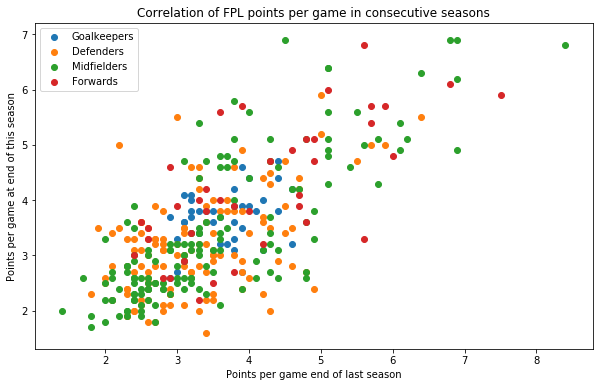

In [34]:
plt.figure(figsize=(10, 6))

plt.scatter(final_combo_df[final_combo_df["element_type"] == 1].points_per_game,
            final_combo_df[final_combo_df["element_type"] == 1].points_per_game_y,
            label = "Goalkeepers")
plt.scatter(final_combo_df[final_combo_df["element_type"] == 2].points_per_game,
            final_combo_df[final_combo_df["element_type"] == 2].points_per_game_y,
            label = "Defenders")
plt.scatter(final_combo_df[final_combo_df["element_type"] == 3].points_per_game,
            final_combo_df[final_combo_df["element_type"] == 3].points_per_game_y,
            label = "Midfielders")
plt.scatter(final_combo_df[final_combo_df["element_type"] == 4].points_per_game,
            final_combo_df[final_combo_df["element_type"] == 4].points_per_game_y,
            label = "Forwards")

plt.title("Correlation of FPL points per game in consecutive seasons")
plt.xlabel("Points per game end of last season")
plt.ylabel("Points per game at end of this season")
plt.legend()

print("Pearson correlation of points per game",
      final_combo_df.points_per_game.corr(final_combo_df.points_per_game_y)
     )
    
plt.show()

## Setting up the machine learning model
For this exercise I will use model stacking and K-fold cross validation on a selection of regression models.

Parameters have been tweaked based on several iterations of the problem but I didn't intend to spend long on that aspect - so improvement is certainly possible.

In [35]:
def evaluate_model(model, X, y):
    cv = RepeatedKFold(n_splits = 5, n_repeats = 10, random_state = 0)
    scores = cross_val_score(model, X, y, scoring = 'r2', cv = cv, n_jobs = -1, error_score = 'raise')
    return scores

stack_model = StackingRegressor(
                estimators = [("KNN", KNeighborsRegressor(n_neighbors = 10, n_jobs = -1)),
                              ("LINEAR", LinearRegression()),
                              ("FOREST", RandomForestRegressor(n_estimators = 100, max_depth = 5, random_state = 0)),
                              ("SVM", SVR())],
                final_estimator = LinearRegression(),
                cv = 5)

In [36]:
print("All positions together")
print("="*20)
X = final_combo_df.iloc[:, 3:-1] # all columns except names/team and target column
y = final_combo_df.iloc[:, -1] # only the target column ("points_per_game_y")

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

results, names = [], []
models = {"KNN": KNeighborsRegressor(n_neighbors = 10, n_jobs = -1),
          "LINEAR": LinearRegression(),
          "FOREST": RandomForestRegressor(n_estimators = 100, max_depth = 5, random_state = 0),
          "SVM": SVR(),
          "STACK": stack_model}

for name, model in models.items():
    scores = evaluate_model(model, X_scaled, y)
    results.append(scores)
    names.append(name)
    print(name, "-", f"r^2 mean score: {np.mean(scores):.3f} (std dev: {np.std(scores):.3f})")

All positions together
KNN - r^2 mean score: 0.486 (std dev: 0.098)
LINEAR - r^2 mean score: 0.550 (std dev: 0.090)
FOREST - r^2 mean score: 0.535 (std dev: 0.094)
SVM - r^2 mean score: 0.549 (std dev: 0.086)
STACK - r^2 mean score: 0.564 (std dev: 0.085)


### Model accuracy = 0.564
This is clearly not an outstanding r^2 score - so with more time, I would consider adjusting features, collecting more data and looking to improve.

However given time constraints and the fact this is purely for fun/learning - we will use this model nonetheless.

### Predicting the points per game of players in the upcoming season

Now we prepare the most recent data from the 2019-20 season, which we will use to estimate the points-per-game for the coming season.

So we will apply our model to the players from Season 2019-20 (that have played enough minutes and are available this season).

In [37]:
final_19_20 = df_19_20.copy()
final_19_20.shape

(211, 26)

In [38]:
# include only players that are available for selection this season

final_19_20 = final_19_20.loc[this_season.index.intersection(final_19_20.index), :]
final_19_20

,first_name,second_name,team_name,element_type,now_cost,selected_by_percent,form,influence,creativity,threat,bps,points_per_game,total_points,minutes,goals_scored,assists,clean_sheets,goals_conceded,own_goals,penalties_saved,penalties_missed,yellow_cards,red_cards,saves,strength_attack,strength_defence
code,,,,,,,,,,,,,,,,,,,,,,,,,,
41270,David,Luiz Moreira Marinho,Arsenal,2,57,5.1,2.6,701.6,106.7,211.0,494,2.8,94,2809,2,1,8,42,0,0,0,5,2,0,1195.0,1215.0
54694,Pierre-Emerick,Aubameyang,Arsenal,4,109,22.4,6.7,1006.0,479.6,1369.0,807,5.7,205,3136,22,5,10,44,0,0,0,3,1,0,1195.0,1215.0
59966,Alexandre,Lacazette,Arsenal,4,92,2.4,4.9,536.4,337.7,861.0,387,3.9,118,1867,10,7,5,25,0,0,0,8,0,0,1195.0,1215.0
80201,Bernd,Leno,Arsenal,1,48,4.2,0.0,843.2,0.0,0.0,591,3.8,114,2649,0,0,7,39,0,1,0,2,0,113,1195.0,1215.0
84450,Granit,Xhaka,Arsenal,3,51,0.8,3.1,486.2,298.5,110.0,408,2.4,73,2586,1,2,10,31,0,0,0,10,0,0,1195.0,1215.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
114128,Jonathan,Castro Otto,Wolves,2,55,2.5,5.0,543.6,379.2,299.0,537,3.5,123,2885,2,3,11,35,0,0,0,4,0,0,1240.0,1185.0
151589,Leander,Dendoncker,Wolves,3,44,8.5,3.7,529.2,160.6,282.0,426,2.6,100,2790,4,0,11,34,1,0,0,5,0,0,1240.0,1185.0
159533,Adama,Traoré,Wolves,3,56,13.2,1.7,727.2,786.4,583.0,522,3.5,130,2599,4,9,7,33,0,0,0,1,0,0,1240.0,1185.0


So our model will be applied to these 184 players, with hopefully enough options in each position for us to choose a high scoring squad.

In [39]:
final_19_20.element_type.value_counts(sort = False)

1    18
2    66
3    78
4    22
Name: element_type, dtype: int64

In [40]:
stack_model.fit(X_scaled, y) # as the stacking model performed best, we use it

X_predict = scaler.fit_transform(final_19_20.iloc[:, 3:])
y_prediction = stack_model.predict(X_predict)

## Final players for selection - with predicted points per game
From the `elements_df` of latest available players, we select those that we have used in our model, add our prediction for this season and then filter our the key features (from last season, except "now_cost" and "chance_") as a reference.

In [41]:
final_players = elements_df.loc[final_19_20.index,
                                ["first_name", "second_name", "team_name", "element_type",
                                 "selected_by_percent", "total_points", "minutes", "form",
                                 "chance_of_playing_next_round",
                                 "now_cost", "points_per_game"]]
final_players["ppg_prediction"] = y_prediction
final_players["ppg_pred_over_cost"] = final_players["ppg_prediction"] / final_players["now_cost"]
final_players

,first_name,second_name,team_name,element_type,selected_by_percent,total_points,minutes,form,chance_of_playing_next_round,now_cost,points_per_game,ppg_prediction,ppg_pred_over_cost
code,,,,,,,,,,,,,
41270,David,Luiz Moreira Marinho,Arsenal,2,1.4,94,2809,0.0,0.0,55,2.8,3.263882,0.059343
54694,Pierre-Emerick,Aubameyang,Arsenal,3,48.4,205,3136,0.0,NaN,120,5.7,5.879074,0.048992
59966,Alexandre,Lacazette,Arsenal,4,3.3,118,1867,0.0,NaN,85,3.9,4.681637,0.055078
80201,Bernd,Leno,Arsenal,1,6.8,114,2649,0.0,NaN,50,3.8,3.679461,0.073589
84450,Granit,Xhaka,Arsenal,3,0.7,73,2586,0.0,NaN,55,2.4,2.418592,0.043974
...,...,...,...,...,...,...,...,...,...,...,...,...,...
114128,Jonathan,Castro Otto,Wolves,2,0.1,123,2885,0.0,0.0,55,3.5,3.530283,0.064187
151589,Leander,Dendoncker,Wolves,3,2.6,100,2790,0.0,NaN,50,2.6,2.670896,0.053418
159533,Adama,Traoré,Wolves,3,20.8,130,2599,0.0,NaN,65,3.5,3.755873,0.057783


## We split the players by position
We do this ahead of running our team selection function - as there are player position constraints.

### We remove specific players 
We also **manually** remove specific players from the top 10/20 that might otherwise be selected as we have external information that means they are likely to not play significantly this season (e.g. transfer rumours, being rotated/substituted more this season, injuries etc).

#### We then pick out the top 5-10 to be used in our team selector
We choose those with the highest predicted points to cost ratio - these will contribute towards the most cost-efficient, high-points team combinations.

In [42]:
gk_choice = final_players[final_players["element_type"] == 1]
gk_choice.sort_values(by = ["ppg_pred_over_cost"], ascending = False).head(10)

,first_name,second_name,team_name,element_type,selected_by_percent,total_points,minutes,form,chance_of_playing_next_round,now_cost,points_per_game,ppg_prediction,ppg_pred_over_cost
code,,,,,,,,,,,,,
131897,Mathew,Ryan,Brighton,1,20.1,135,3420,0.0,NaN,45,3.6,3.744783,0.083217
58376,Alex,McCarthy,Southampton,1,23.6,104,2520,0.0,NaN,45,3.7,3.603097,0.080069
37915,Hugo,Lloris,Spurs,1,5.2,98,1808,0.0,NaN,55,4.7,4.259936,0.077453
67089,Martin,Dubravka,Newcastle,1,0.5,143,3420,0.0,0.0,50,3.8,3.770989,0.075420
21205,Tom,Heaton,Aston Villa,1,0.1,59,1794,0.0,0.0,45,3.0,3.381014,0.075134
109745,Kepa,Arrizabalaga,Chelsea,1,2.3,90,2970,0.0,NaN,50,2.7,3.728580,0.074572
111234,Jordan,Pickford,Everton,1,4.7,117,3420,0.0,NaN,50,3.1,3.723737,0.074475
116535,Alisson,Ramses Becker,Liverpool,1,12.5,122,2543,0.0,NaN,60,4.2,4.430887,0.073848
80201,Bernd,Leno,Arsenal,1,6.8,114,2649,0.0,NaN,50,3.8,3.679461,0.073589


In [43]:
# delete injured and transfer/rotation risks

# Heaton (inj), Leno (rot), Henderson (rot), Guaita (trf)
# Fabianski (trf), De Gea (rot), Dubravka (inj), Arrizabalaga (rot/trf)
gk_choice.drop([21205, 80201, 172649, 40836, 37096,
                51940, 67089, 109745], errors = "ignore", inplace = True)

C:\Users\Dexx6\Anaconda3\lib\site-packages\pandas\core\frame.py:4169: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [44]:
gk_top = gk_choice.sort_values(by = ["ppg_pred_over_cost"], ascending = False).head(5)
gk_top

,first_name,second_name,team_name,element_type,selected_by_percent,total_points,minutes,form,chance_of_playing_next_round,now_cost,points_per_game,ppg_prediction,ppg_pred_over_cost
code,,,,,,,,,,,,,
131897,Mathew,Ryan,Brighton,1,20.1,135,3420,0.0,NaN,45,3.6,3.744783,0.083217
58376,Alex,McCarthy,Southampton,1,23.6,104,2520,0.0,NaN,45,3.7,3.603097,0.080069
37915,Hugo,Lloris,Spurs,1,5.2,98,1808,0.0,NaN,55,4.7,4.259936,0.077453
111234,Jordan,Pickford,Everton,1,4.7,117,3420,0.0,NaN,50,3.1,3.723737,0.074475
116535,Alisson,Ramses Becker,Liverpool,1,12.5,122,2543,0.0,NaN,60,4.2,4.430887,0.073848


In [45]:
def_choice = final_players[final_players["element_type"] == 2]
def_choice.sort_values(by = ["ppg_pred_over_cost"], ascending = False).head(20)

,first_name,second_name,team_name,element_type,selected_by_percent,total_points,minutes,form,chance_of_playing_next_round,now_cost,points_per_game,ppg_prediction,ppg_pred_over_cost
code,,,,,,,,,,,,,
87835,Matt,Doherty,Spurs,2,26.2,167,2836,0.0,NaN,60,4.6,4.613909,0.076898
108416,John,Egan,Sheffield Utd,2,17.7,133,3187,0.0,NaN,50,3.7,3.649270,0.072985
39487,Erik,Pieters,Burnley,2,1.5,77,1876,0.0,NaN,45,3.2,3.276349,0.072808
57410,Nicolás,Otamendi,Man City,2,0.7,82,1710,0.0,NaN,50,3.4,3.625744,0.072515
90585,Willy,Boly,Wolves,2,2.4,97,1980,0.0,NaN,55,4.4,3.914372,0.071170
17997,Phil,Bardsley,Burnley,2,0.7,78,1890,0.0,NaN,45,3.7,3.169577,0.070435
102380,Antonio,Rüdiger,Chelsea,2,2.3,63,1710,0.0,NaN,50,3.1,3.457401,0.069148
122798,Andrew,Robertson,Liverpool,2,13.4,181,3111,0.0,NaN,70,5.0,4.830097,0.069001
97032,Virgil,van Dijk,Liverpool,2,26.6,178,3420,0.0,NaN,65,4.7,4.472988,0.068815


In [46]:
# delete injured and transfer/rotation risks

# Otamendi (trf), Pieters (rot), Cahill (inj), Chilwell (inj)
# Rudiger (inj), Bardsley (rot), Taylor (inj), Shaw (inj)
def_choice.drop([57410, 39487, 19419, 172850, 102380,
                17997, 103914, 106760], errors = "ignore", inplace = True)
def_top = def_choice.sort_values(by = ["ppg_pred_over_cost"], ascending = False).head(10)
def_top

C:\Users\Dexx6\Anaconda3\lib\site-packages\pandas\core\frame.py:4169: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,first_name,second_name,team_name,element_type,selected_by_percent,total_points,minutes,form,chance_of_playing_next_round,now_cost,points_per_game,ppg_prediction,ppg_pred_over_cost
code,,,,,,,,,,,,,
87835,Matt,Doherty,Spurs,2,26.2,167,2836,0.0,NaN,60,4.6,4.613909,0.076898
108416,John,Egan,Sheffield Utd,2,17.7,133,3187,0.0,NaN,50,3.7,3.649270,0.072985
90585,Willy,Boly,Wolves,2,2.4,97,1980,0.0,NaN,55,4.4,3.914372,0.071170
122798,Andrew,Robertson,Liverpool,2,13.4,181,3111,0.0,NaN,70,5.0,4.830097,0.069001
97032,Virgil,van Dijk,Liverpool,2,26.6,178,3420,0.0,NaN,65,4.7,4.472988,0.068815
83299,Lewis,Dunk,Brighton,2,9.5,128,3230,0.0,NaN,50,3.6,3.415988,0.068320
169187,Trent,Alexander-Arnold,Liverpool,2,56.2,210,3173,0.0,NaN,75,5.5,5.013491,0.066847
214590,Aaron,Wan-Bissaka,Man Utd,2,12.2,127,3070,0.0,NaN,55,3.6,3.620050,0.065819
58621,Kyle,Walker,Man City,2,5.1,114,2392,0.0,NaN,60,3.9,3.933716,0.065562


In [47]:
mid_choice = final_players[final_players["element_type"] == 3]
mid_choice.sort_values(by = ["ppg_pred_over_cost"], ascending = False).head(20)

,first_name,second_name,team_name,element_type,selected_by_percent,total_points,minutes,form,chance_of_playing_next_round,now_cost,points_per_game,ppg_prediction,ppg_pred_over_cost
code,,,,,,,,,,,,,
153723,John,Lundstram,Sheffield Utd,3,13.7,144,2452,0.0,NaN,55,4.2,3.990276,0.072550
103025,Riyad,Mahrez,Man City,3,2.0,175,1934,0.0,NaN,85,5.3,5.623265,0.066156
85971,Heung-Min,Son,Spurs,3,30.0,169,2478,0.0,NaN,90,5.6,5.856616,0.065074
148508,Mahmoud Ahmed,Ibrahim Hassan,Aston Villa,3,1.3,98,1936,0.0,NaN,55,2.9,3.460669,0.062921
116216,Leandro,Trossard,Brighton,3,0.4,104,2004,0.0,NaN,60,3.4,3.773659,0.062894
168580,Ayoze,Pérez,Leicester,3,3.7,129,1998,0.0,NaN,65,3.9,4.085265,0.062850
170137,Allan,Saint-Maximin,Newcastle,3,23.2,92,1860,0.0,NaN,55,3.5,3.415693,0.062104
176413,Christian,Pulisic,Chelsea,3,10.4,127,1717,0.0,100.0,85,5.1,5.260227,0.061885
195851,Scott,McTominay,Man Utd,3,0.3,74,1765,0.0,NaN,50,2.7,3.069354,0.061387


In [48]:
# delete injured and transfer/rotation risks

# Silva (inj), Maddison (inj), Shelvey (inj), Mooy (inj)
# Henderson (inj), McTominay (rot)
mid_choice.drop([165809, 172780, 50232, 74471, 56979,
                195851], errors = "ignore", inplace = True)
mid_top = mid_choice.sort_values(by = ["ppg_pred_over_cost"], ascending = False).head(10)
mid_top

C:\Users\Dexx6\Anaconda3\lib\site-packages\pandas\core\frame.py:4169: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,first_name,second_name,team_name,element_type,selected_by_percent,total_points,minutes,form,chance_of_playing_next_round,now_cost,points_per_game,ppg_prediction,ppg_pred_over_cost
code,,,,,,,,,,,,,
153723,John,Lundstram,Sheffield Utd,3,13.7,144,2452,0.0,NaN,55,4.2,3.990276,0.072550
103025,Riyad,Mahrez,Man City,3,2.0,175,1934,0.0,NaN,85,5.3,5.623265,0.066156
85971,Heung-Min,Son,Spurs,3,30.0,169,2478,0.0,NaN,90,5.6,5.856616,0.065074
148508,Mahmoud Ahmed,Ibrahim Hassan,Aston Villa,3,1.3,98,1936,0.0,NaN,55,2.9,3.460669,0.062921
116216,Leandro,Trossard,Brighton,3,0.4,104,2004,0.0,NaN,60,3.4,3.773659,0.062894
168580,Ayoze,Pérez,Leicester,3,3.7,129,1998,0.0,NaN,65,3.9,4.085265,0.062850
170137,Allan,Saint-Maximin,Newcastle,3,23.2,92,1860,0.0,NaN,55,3.5,3.415693,0.062104
176413,Christian,Pulisic,Chelsea,3,10.4,127,1717,0.0,100.0,85,5.1,5.260227,0.061885
108823,Bamidele,Alli,Spurs,3,3.9,117,1845,0.0,NaN,80,4.7,4.771140,0.059639


In [49]:
fwd_choice = final_players[final_players["element_type"] == 4]
fwd_choice.sort_values(by = ["ppg_pred_over_cost"], ascending = False)

,first_name,second_name,team_name,element_type,selected_by_percent,total_points,minutes,form,chance_of_playing_next_round,now_cost,points_per_game,ppg_prediction,ppg_pred_over_cost
code,,,,,,,,,,,,,
57531,Michail,Antonio,West Ham,4,11.3,111,1767,0.0,NaN,65,4.6,4.874120,0.074986
148225,Anthony,Martial,Man Utd,4,12.5,200,2625,0.0,NaN,90,6.2,5.639061,0.062656
173879,Tammy,Abraham,Chelsea,4,5.2,153,2206,0.0,NaN,75,4.5,4.647671,0.061969
115382,Neal,Maupay,Brighton,4,1.9,131,2763,0.0,NaN,65,3.5,3.978758,0.061212
103123,Sébastien,Haller,West Ham,4,0.6,102,2259,0.0,NaN,65,3.2,3.949402,0.060760
102057,Raúl,Jiménez,Wolves,4,19.0,194,3241,0.0,NaN,85,5.1,5.159176,0.060696
44683,Jay,Rodriguez,Burnley,4,0.9,100,2002,0.0,NaN,60,2.8,3.609997,0.060167
75115,Callum,Wilson,Newcastle,4,8.7,116,2906,0.0,NaN,65,3.3,3.854312,0.059297
60689,Chris,Wood,Burnley,4,2.6,136,2436,0.0,NaN,65,4.2,3.840819,0.059090


In [50]:
# delete injured and transfer/rotation risks

# Antonio (rot), Abraham (rot)
fwd_choice.drop([57531, 173879], errors = "ignore", inplace = True)
fwd_top = fwd_choice.sort_values(by = ["ppg_pred_over_cost"], ascending = False).head(7)
fwd_top

C:\Users\Dexx6\Anaconda3\lib\site-packages\pandas\core\frame.py:4169: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,first_name,second_name,team_name,element_type,selected_by_percent,total_points,minutes,form,chance_of_playing_next_round,now_cost,points_per_game,ppg_prediction,ppg_pred_over_cost
code,,,,,,,,,,,,,
148225,Anthony,Martial,Man Utd,4,12.5,200,2625,0.0,NaN,90,6.2,5.639061,0.062656
115382,Neal,Maupay,Brighton,4,1.9,131,2763,0.0,NaN,65,3.5,3.978758,0.061212
103123,Sébastien,Haller,West Ham,4,0.6,102,2259,0.0,NaN,65,3.2,3.949402,0.060760
102057,Raúl,Jiménez,Wolves,4,19.0,194,3241,0.0,NaN,85,5.1,5.159176,0.060696
44683,Jay,Rodriguez,Burnley,4,0.9,100,2002,0.0,NaN,60,2.8,3.609997,0.060167
75115,Callum,Wilson,Newcastle,4,8.7,116,2906,0.0,NaN,65,3.3,3.854312,0.059297
60689,Chris,Wood,Burnley,4,2.6,136,2436,0.0,NaN,65,4.2,3.840819,0.059090


## Brute force optimiser
Below we use brute force - calculating every possible combination of a 15 person squad with the following constraints:
     * 2 goalkeepers
     * 5 defenders
     * 5 midfielders
     * 3 forwards
     * No more than 3 players from any team
     * Overall squad 'cost' <= 1000

In [61]:
def brute_force_team_selector(gks, defs, mids, fwds):
    
    team_combos = [] # will be list of squads (15 players in total)
    
    # for every 2 goalkeepers
    for gk1, gk2 in list(combinations(gks.index, 2)):
        for def1, def2, def3, def4, def5 in list(combinations(defs.index, 5)):
            for mid1, mid2, mid3, mid4, mid5 in list(combinations(mids.index, 5)):
                for fwd1, fwd2, fwd3 in list(combinations(fwds.index, 3)):
                    team_combos.append([gk1, gk2,
                                        def1, def2, def3, def4, def5,
                                        mid1, mid2, mid3, mid4, mid5,
                                        fwd1, fwd2, fwd3])
    
    filtered_teams = {} # dictionary of the team squad total points
    for players in team_combos:
        df = pd.DataFrame(columns = ["first_name", "second_name", "team_name", "element_type",
                                 "selected_by_percent", "total_points", "minutes", "points_per_game",
                                 "form", "ppg_pred_over_cost", "now_cost", "ppg_prediction"])
        df = df.append(gks.loc[players[0:2], :], sort = False)
        df = df.append(defs.loc[players[2:7], :], sort = False)
        df = df.append(mids.loc[players[7:12], :], sort = False)
        df = df.append(fwds.loc[players[12:], :], sort = False)
        team_cost = df.now_cost.sum()
        if (team_cost <= 1000) and (df.team_name.value_counts() < 4).all():
            filtered_teams[df.ppg_prediction.sum()] = df
            
    return filtered_teams

Below I show the elapsed time for the function - around 2 minutes with the below settings.

I did also run the data on larger sets of the players, however it yields the same top team below.

In [62]:
start = time.time()

team_choices_dfs = brute_force_team_selector(gk_top[:-2], def_top[:-3], mid_top[:-3], fwd_top[:-3])

end = time.time()
print("Time elapsed in minutes:", (end - start)/60)

Time elapsed in minutes: 2.8073135296503704


In [63]:
len(team_choices_dfs)

3740

In [64]:
max(team_choices_dfs) # max predicted points per game for total 15 person squad

67.81894423893289

# Final team selection
Based on the output of the above, the below was my final team selection.

I chose the formation based on the highest points per game output possible (formation constaints are 1 GK, >= 3 DEF and >= 1 FWD).

I will chose the captain/vice captain based on highest points per game and how easy the weekly fixture is.

Otherwise the idea will be to make no transfers to this team unless forced to by injuries/transfers/other factors meaning these players are unlikely to play most of the season.

In [65]:
team_choices_dfs[max(team_choices_dfs)].sort_values(by = ['element_type', 'ppg_prediction'], ascending = False)

,first_name,second_name,team_name,element_type,selected_by_percent,total_points,minutes,points_per_game,form,ppg_pred_over_cost,now_cost,ppg_prediction,chance_of_playing_next_round
148225,Anthony,Martial,Man Utd,4,12.5,200,2625,6.2,0.0,0.062656,90,5.639061,NaN
102057,Raúl,Jiménez,Wolves,4,19.0,194,3241,5.1,0.0,0.060696,85,5.159176,NaN
115382,Neal,Maupay,Brighton,4,1.9,131,2763,3.5,0.0,0.061212,65,3.978758,NaN
85971,Heung-Min,Son,Spurs,3,30.0,169,2478,5.6,0.0,0.065074,90,5.856616,NaN
103025,Riyad,Mahrez,Man City,3,2.0,175,1934,5.3,0.0,0.066156,85,5.623265,NaN
168580,Ayoze,Pérez,Leicester,3,3.7,129,1998,3.9,0.0,0.062850,65,4.085265,NaN
153723,John,Lundstram,Sheffield Utd,3,13.7,144,2452,4.2,0.0,0.072550,55,3.990276,NaN
148508,Mahmoud Ahmed,Ibrahim Hassan,Aston Villa,3,1.3,98,1936,2.9,0.0,0.062921,55,3.460669,NaN
169187,Trent,Alexander-Arnold,Liverpool,2,56.2,210,3173,5.5,0.0,0.066847,75,5.013491,NaN
122798,Andrew,Robertson,Liverpool,2,13.4,181,3111,5.0,0.0,0.069001,70,4.830097,NaN


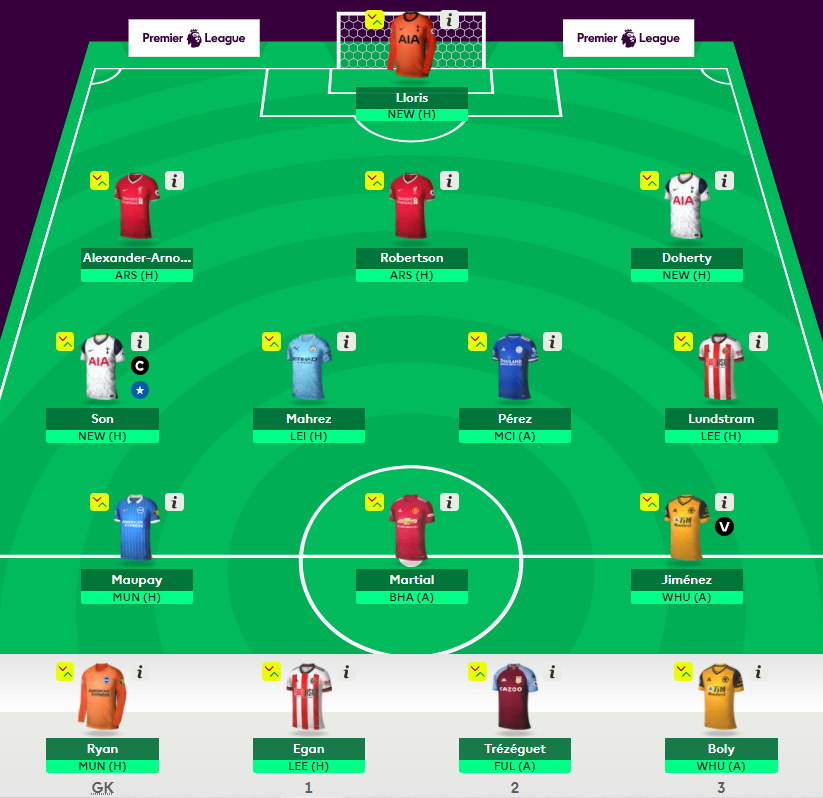